# Klasterizacija
### Jovan Juric 1206
Cilj ovog projekta jeste kategorizovati države po stepenu razvijenosti na osnovu socio-ekonomskih i zdravstvenih faktora.
Dataset je preuzet sa linka: https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data

## 1 Deskripcija podataka

In [1]:
import seaborn as sb
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.datasets import make_blobs
palette = sb.color_palette("Paired")

In [2]:
df = pd.read_csv('Country-data.csv', sep=',')
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [3]:
df2 = pd.read_csv('data-dictionary.csv',sep=',')
print(df2)

  Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...


In [4]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


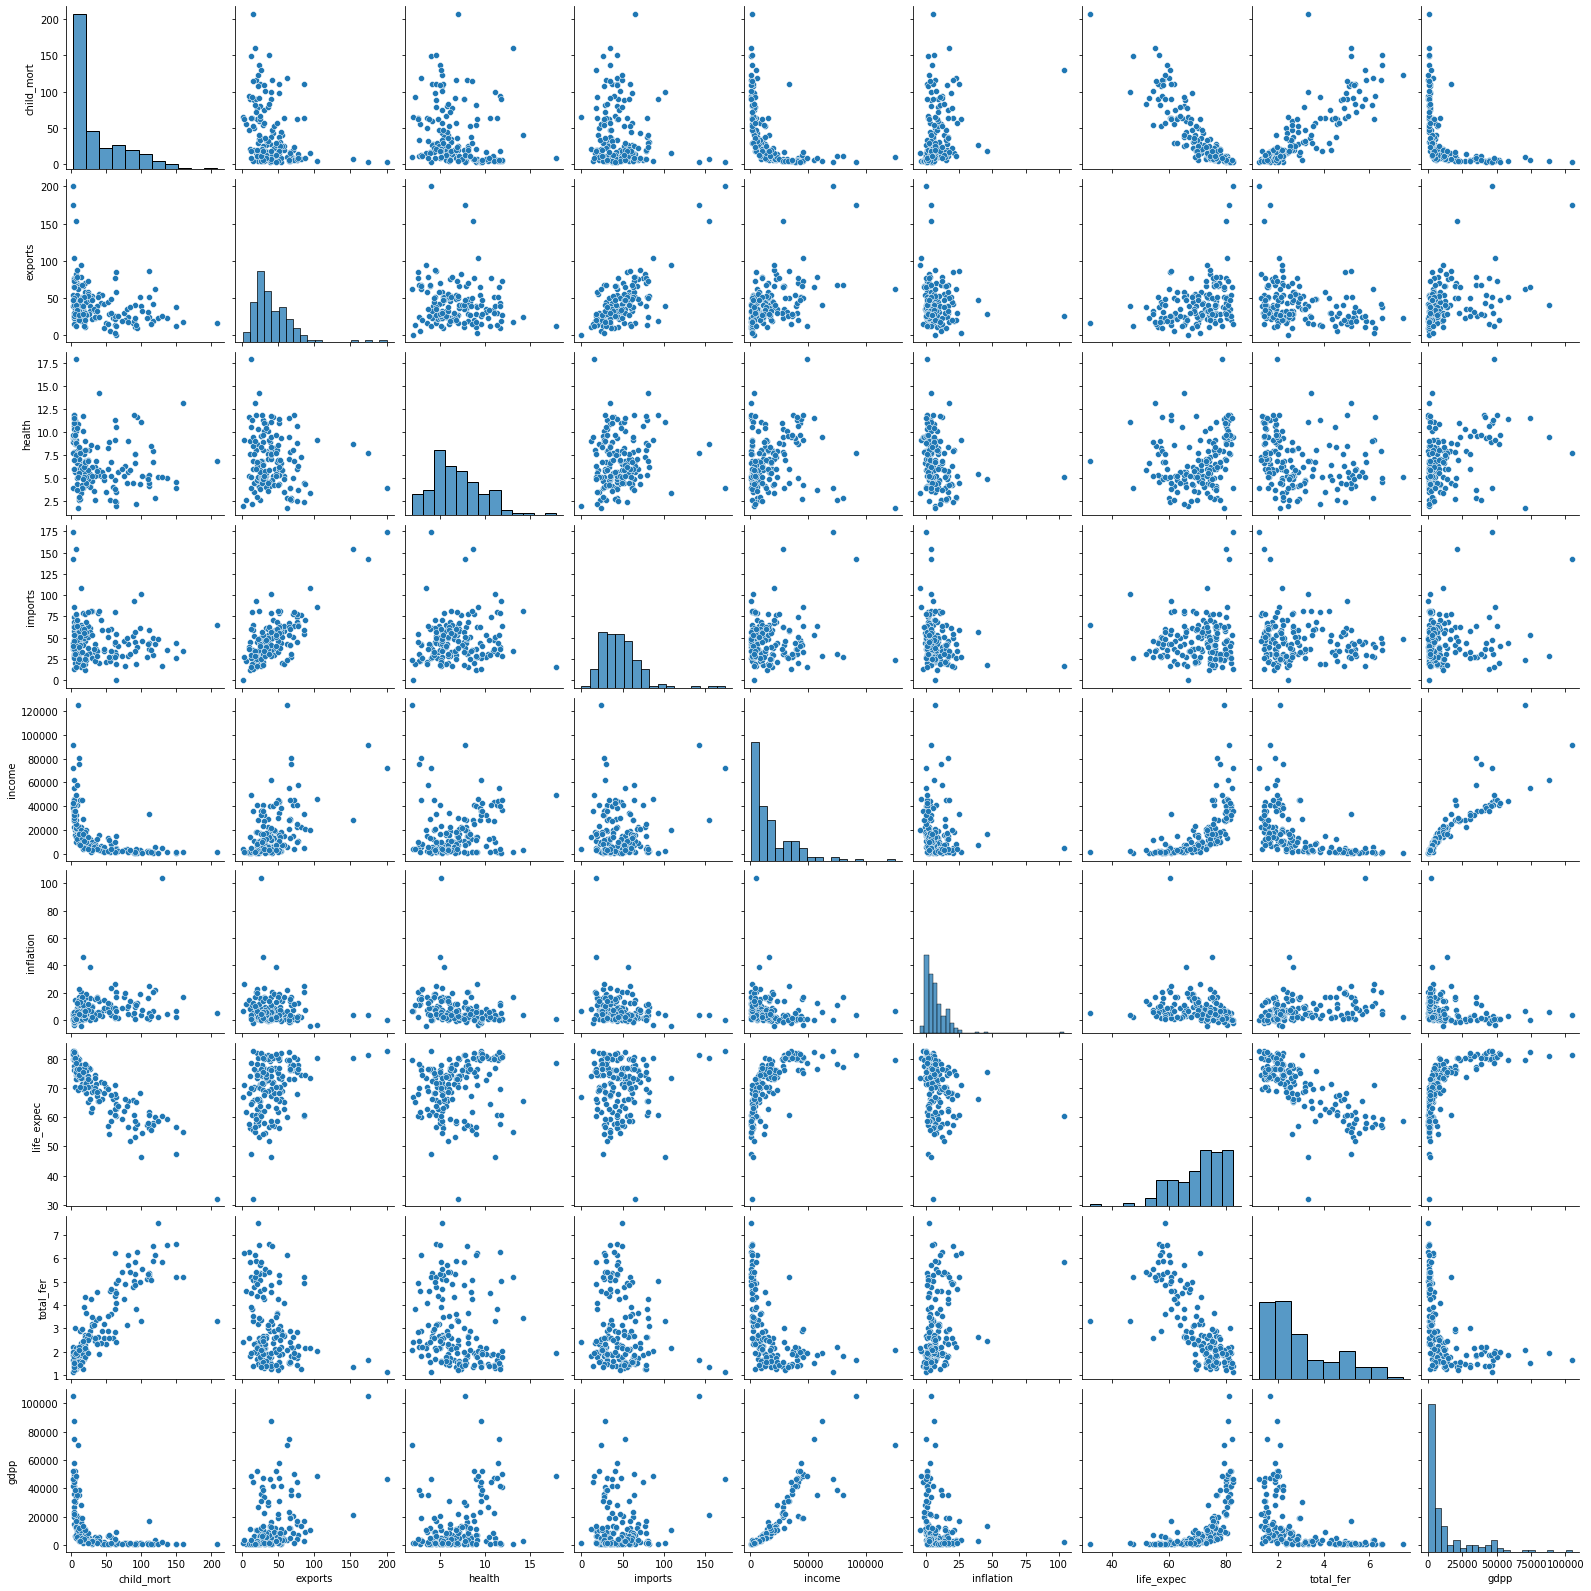

In [5]:
data = pd.DataFrame(df.iloc[:,1:])
sb.pairplot(data)

## 2 Transformacija podataka i redukcija dimenzionalnosti

[]

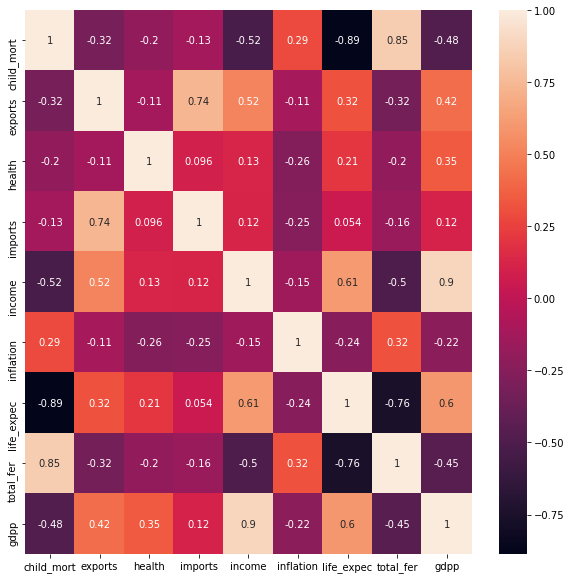

In [6]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr(),annot=True)
plt.plot()

Iz heatmape korelacije možemo videti da su gdpp i income u gotovo perfektnoj korelaciji što i ima smisla. Međutim ne mora da znači da je jedno uslovljeno drugim. U nastavku rada ćemo videti da li je potrebno izvršiti redukciju dimenzionalnosti.

Najpre je potrebni skalirati podatke jer nisu normalno distribuirani.

In [7]:
scaled_data = StandardScaler().fit_transform(data)

Total no. of principal components = 9


<function matplotlib.pyplot.show(close=None, block=None)>

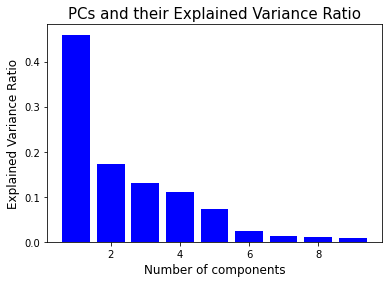

In [8]:
from sklearn.decomposition import PCA
pc = PCA(svd_solver='auto')
pc.fit(scaled_data)
print('Total no. of principal components =',pc.n_components_)
variance = pc.explained_variance_ratio_
plt.bar([i+1 for i, _ in enumerate(variance)],variance,color='blue')
plt.title('PCs and their Explained Variance Ratio', fontsize=15)
plt.xlabel('Number of components',fontsize=12)
plt.ylabel('Explained Variance Ratio',fontsize=12)
plt.show

## 3.1 K means 

Najpre treba da saznamo na koliko klastera treba da podelimo podatke. To postižemo zahvaljući elbow krivom kao i koeficijentu siluete. Za elbow krivu rezultat dobijamo tako što na naš dataset primenim razne brojeve klastera. Kao rezultat dobijamo linija koja je u obliku iskrivljene ruke i najoptimalniji broj klastera jeste mesto gde se nalazi rame tj. elbow na engleskom po čemu je ova kriva dobila naziv. 

Koeficijent siluete nam pokazuje koliko su centralne tačke klastera udaljene od najdaljih tačaka unutar klastera kao i udaljenosti od tačaka drugih klastera. Kod ovog koeficijenta veće vrednosti su u glavnom bolje.

Kao još jednu meru kvalitete klasera koristićemo i Kalinski Harbaš indeks (takođe poznat kao kriterijum odnosa varijance) Predstavlja odnos sume disperzije između klastera i disperzije unutar klastera. Veći indeks pokazuje bolje rezultate.

In [9]:
sse=[] #Square root error
silhouette_coefficients = []
cal_har_coefficients = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    
    sse.append(kmeans.inertia_)
    score = silhouette_score(data, kmeans.labels_)
    ch_score = calinski_harabasz_score(data,kmeans.labels_)
    
    silhouette_coefficients.append(score)
    cal_har_coefficients.append(ch_score)

<function matplotlib.pyplot.show(close=None, block=None)>

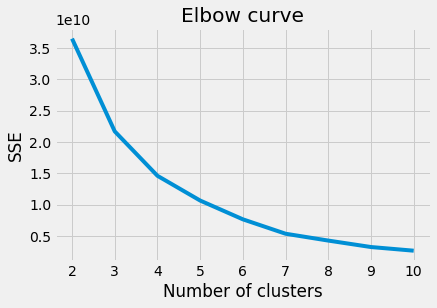

In [10]:
plt.style.use('fivethirtyeight')
plt.plot(range(2,11),sse)
plt.xticks(range(2,11))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow curve')
plt.show

Kao što možemo videti u ovom primeru 'rame' krive se ne može najjasnije odrediti jer može biti i 3 i 4. Iz tog razloga vršimo više funkcija za određivanje broja klastera.

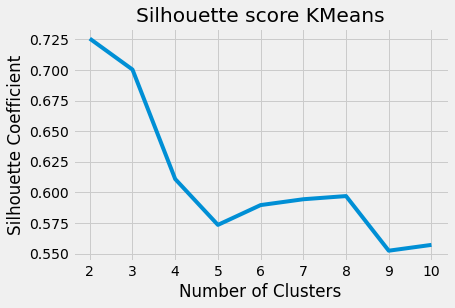

In [11]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette score KMeans')
plt.show()

Iz grafika elbow krive i ovog grafa možemo zaključiti da je najoptimalnije ovaj dataset podeliti na 3 klastera. Naredni korak je istrenirati model za 3 klastera.

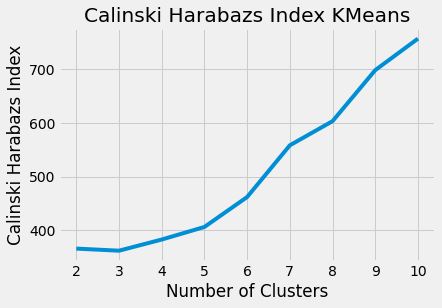

In [12]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), cal_har_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski Harabazs Index")
plt.title('Calinski Harabazs Index KMeans')
plt.show()

In [13]:
kmeans = KMeans(n_clusters=3)
kmeans.fit_predict(scaled_data)
pred = kmeans.labels_
data['Cluster'] = pred

U narednih par slika možemo da vidimo kako su države klasterizovane. Na y osi smo kao parametar uzeli bruto domaćeg proizvoda dok na x osi imamo mortalitet dece, prosečan životni vek i inflaciju unutar država.

<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

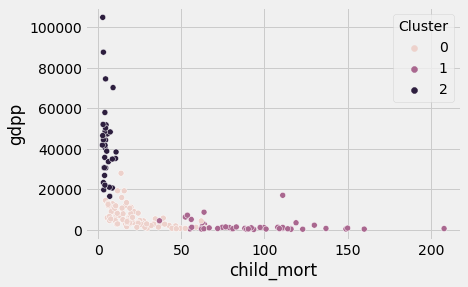

In [14]:
sb.scatterplot(x = data['child_mort'], y = data['gdpp'],hue='Cluster',data = data)

<AxesSubplot:xlabel='life_expec', ylabel='gdpp'>

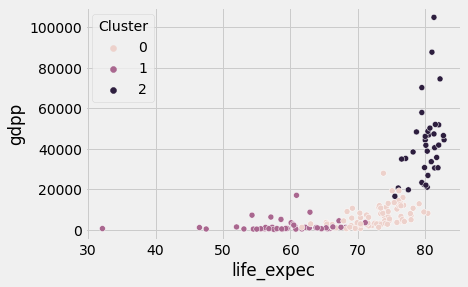

In [15]:
sb.scatterplot(x = data['life_expec'], y = data['gdpp'],hue='Cluster',data = data)

<AxesSubplot:xlabel='inflation', ylabel='gdpp'>

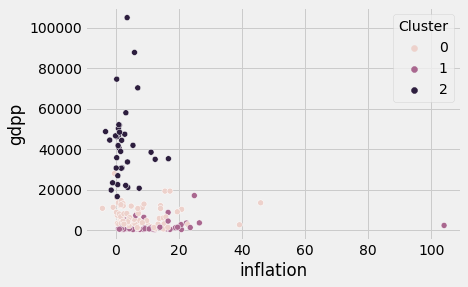

In [16]:
sb.scatterplot(x = data['inflation'], y = data['gdpp'],hue='Cluster',data = data)

<AxesSubplot:xlabel='income', ylabel='gdpp'>

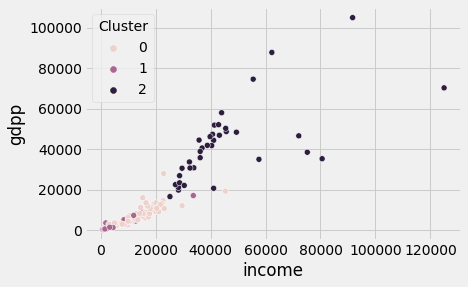

In [17]:
sb.scatterplot(x = data['income'], y = data['gdpp'],hue='Cluster',data = data)

In [18]:
df['Cluster'] = data['Cluster']

In [19]:
def how_developed(country, df):
    d = {
     0:'developed' ,
     1:'developing',
     2:'underdeveoped'
    }
    index = df['country'].loc[lambda x: x==country].index[0]
    cluster = df['Cluster'][index]
    print(country,' is ', d[cluster])
    
how_developed('Serbia',df)

Serbia  is  developed


Možemo videti da kmeans algoritam radi prilično dobar posao za klasterovanje ovog dataset-a. U razvijenim državama je veća zarada i duži životni vek dok je u nerazvijenim obrnuto. 

## 3.2 DBSCAN

In [20]:
from sklearn.cluster import DBSCAN
sse=[] #Square root error
silhouette_coefficients = []
cal_har_coefficients = []
# del data['Cluster']
for k in range(2,11):
    dbscan = DBSCAN(min_samples=k,eps=1.1).fit(scaled_data)
    score = silhouette_score(data, dbscan.labels_)
    ch_score = calinski_harabasz_score(data,dbscan.labels_)
    silhouette_coefficients.append(score)
    cal_har_coefficients.append(ch_score)

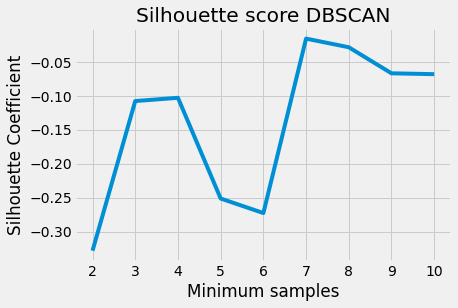

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Minimum samples")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette score DBSCAN')
plt.show()

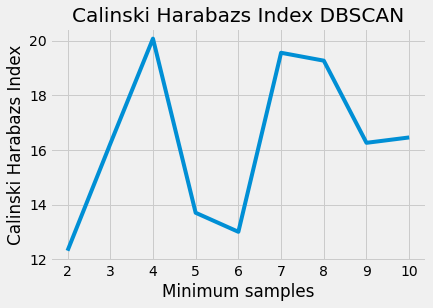

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), cal_har_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Minimum samples")
plt.ylabel("Calinski Harabazs Index")
plt.title('Calinski Harabazs Index DBSCAN')
plt.show()

<AxesSubplot:xlabel='income', ylabel='gdpp'>

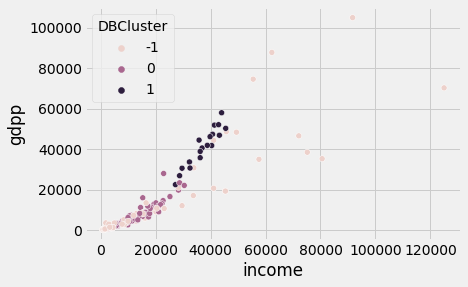

In [23]:
dbscan = DBSCAN(min_samples=8,eps=1.15).fit(scaled_data)
data['DBCluster'] = dbscan.labels_
sb.scatterplot(x = data['income'], y = data['gdpp'],hue='DBCluster',data = data)

<AxesSubplot:xlabel='inflation', ylabel='gdpp'>

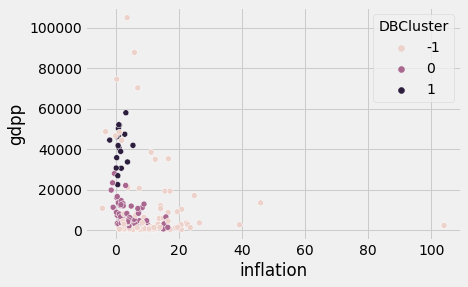

In [24]:
sb.scatterplot(x = data['inflation'], y = data['gdpp'],hue='DBCluster',data = data)

<AxesSubplot:xlabel='life_expec', ylabel='gdpp'>

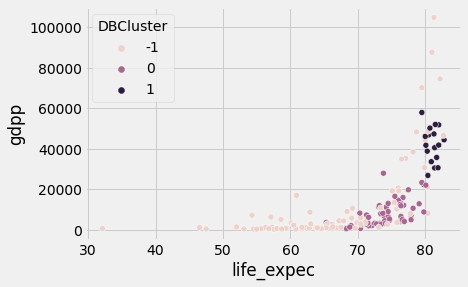

In [25]:
sb.scatterplot(x = data['life_expec'], y = data['gdpp'],hue='DBCluster',data = data)

<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

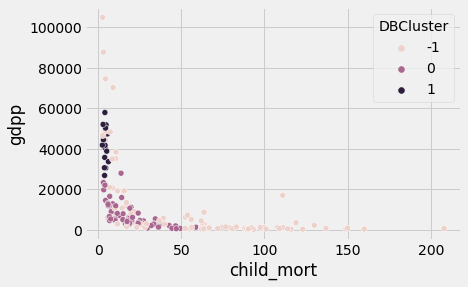

In [26]:
sb.scatterplot(x = data['child_mort'], y = data['gdpp'],hue='DBCluster',data = data)

Iz dobijenih rezultata možemo videti da DBSCAN algoritam ne radi dobar posao kao KMeans algoritam.

## 3.3 Hierarhijsko klasterovanje

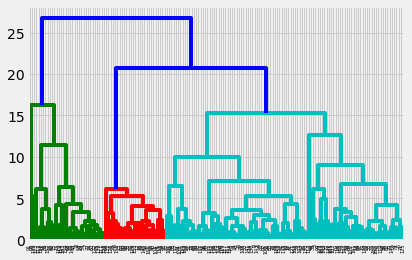

In [27]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(scaled_data,method='ward'))

In [28]:
silhouette_coefficients = []
cal_har_coefficients = []
del data['DBCluster']
for k in range(2,11):
    hclustering = AgglomerativeClustering(n_clusters=k, affinity = 'euclidean', linkage = 'ward')
    hclustering.fit(scaled_data)
    score = silhouette_score(data, hclustering.labels_)
    ch_score = calinski_harabasz_score(data,hclustering.labels_)
    silhouette_coefficients.append(score)
    cal_har_coefficients.append(ch_score)

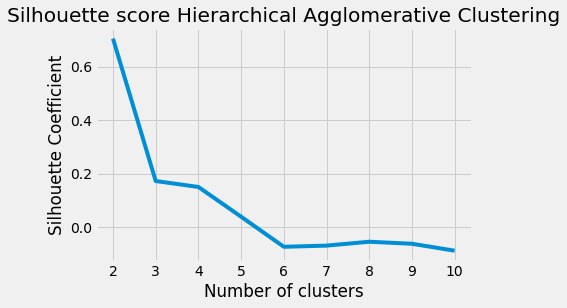

In [29]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette score Hierarchical Agglomerative Clustering')
plt.show()

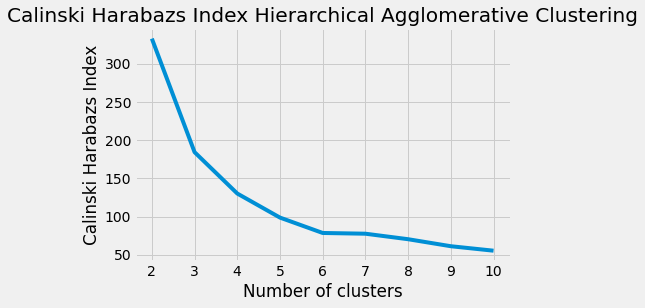

In [30]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), cal_har_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabazs Index")
plt.title('Calinski Harabazs Index Hierarchical Agglomerative Clustering')
plt.show()

<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

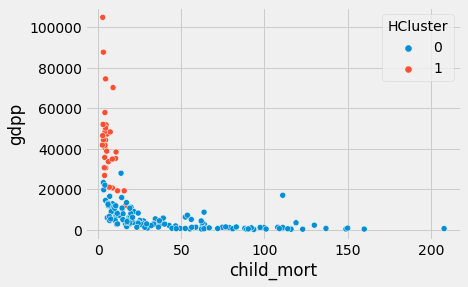

In [31]:
hclustering = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'ward')
hclustering.fit(scaled_data)
data['HCluster'] = hclustering.labels_
sb.scatterplot(x = data['child_mort'], y = data['gdpp'],hue='HCluster',data = data)

<AxesSubplot:xlabel='life_expec', ylabel='gdpp'>

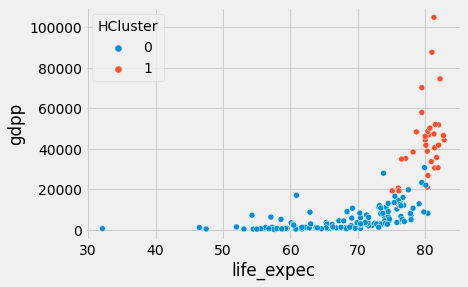

In [32]:
sb.scatterplot(x = data['life_expec'], y = data['gdpp'],hue='HCluster',data = data)

<AxesSubplot:xlabel='inflation', ylabel='gdpp'>

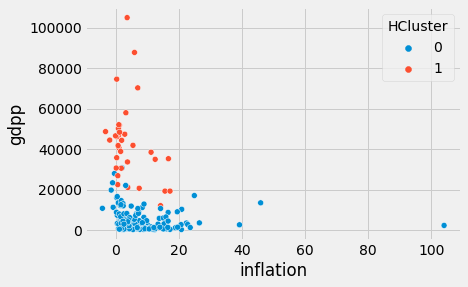

In [33]:
sb.scatterplot(x = data['inflation'], y = data['gdpp'],hue='HCluster',data = data)

<AxesSubplot:xlabel='income', ylabel='gdpp'>

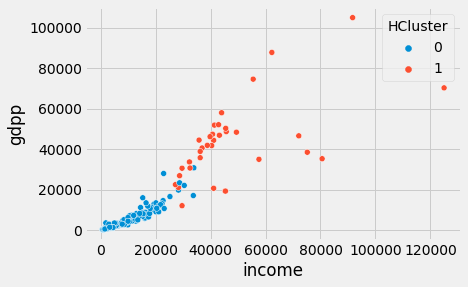

In [34]:
sb.scatterplot(x = data['income'], y = data['gdpp'],hue='HCluster',data = data)

Algoritam za hijerarhijsko klasterovanje pokazuje bolje rezultate od DBSCAN algoritma međutim mali broj država stavlja u grupu 'nerazvijenih' zemalja što možda i nije baš najbolja kategorizacija. Samim tim zaključujemo da je KMeans algoritam najbolji za rešavanje ovog problema.